In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import yellowbrick as yb

from yellowbrick.features import RadViz
from sklearn.metrics import accuracy_score
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.features import FeatureImportances
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def connectDB(DB):
    # connect to the PostgreSQL server
    return psycopg2.connect(
        database=DB,
        user="postgres",
        password="Georgetown16",
        host="database-1.c5vispb5ezxg.us-east-1.rds.amazonaws.com",
        port='5432')

def disconnectDB():
    cur.close()
    conn.close()

In [3]:
conn = connectDB("Dataset")

# extract everything from 'table_name' into a dataframe
df = pd_sql.read_sql(f"select * from public.\"featureSTG\" ", con=conn)
#code to be able to view all the columns in pandas dataframe
pd.set_option('display.max_columns', 50) 
              

# Feature Analysis

In [4]:
df = df[['code_module', 'module_domain', 'module_presentation_length','year','term', 'num_of_prev_attempts',
                    'final_result', 'date_registration', 'disability', 'gender', 'age_band', 'region', 'highest_education', 
                    'imd_band', 'studied_credits', 'b4_sum_clicks', 'half_sum_clicks', 'std_half_score']]

In [5]:
feature_list = df

In [6]:
feature_list = df.loc[(df.year == 0)&(df.module_domain==0)&(df.code_module != 6)]

In [7]:
#remove null values
feature_list = feature_list.dropna()

In [8]:
#check to make sure that code module 6 or Class GGG is removed
feature_list['code_module'].value_counts()

1    3009
0     349
Name: code_module, dtype: int64

In [9]:
feature_list.head()

,code_module,module_domain,module_presentation_length,year,term,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
4,0,0,268,0,0,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000
5,1,0,240,0,1,2,0,-47.0,0,1,0,1,1,2.0,60,14.0,147.0,38.813953
8,1,0,268,0,0,0,1,-27.0,0,0,0,9,2,5.0,60,6.0,365.0,89.612903
14,1,0,240,0,1,0,1,-73.0,0,1,0,1,1,2.0,120,5.0,1465.0,63.000000
36,1,0,268,0,0,0,0,-43.0,1,0,1,4,1,4.0,120,0.0,239.0,59.951613


In [10]:
feature_list = feature_list[feature_list.columns.drop(['module_domain', 'year', 'term'])]

In [11]:
feature_list.to_csv('feature_list.csv')

# Feature Selection

In [12]:
X = feature_list[["half_sum_clicks","gender","highest_education", "code_module", "studied_credits"]].values
        
y = feature_list["final_result"].values

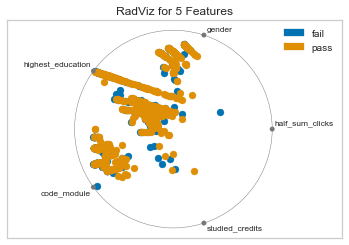

In [13]:
classes = ["fail", "pass"]
features = ["half_sum_clicks", "gender", "highest_education", "code_module", "studied_credits"]
        
sns.set_palette("colorblind")
# Instantiate the visualizer
visualizer = RadViz (
    classes=classes,
    features = features
)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
//anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


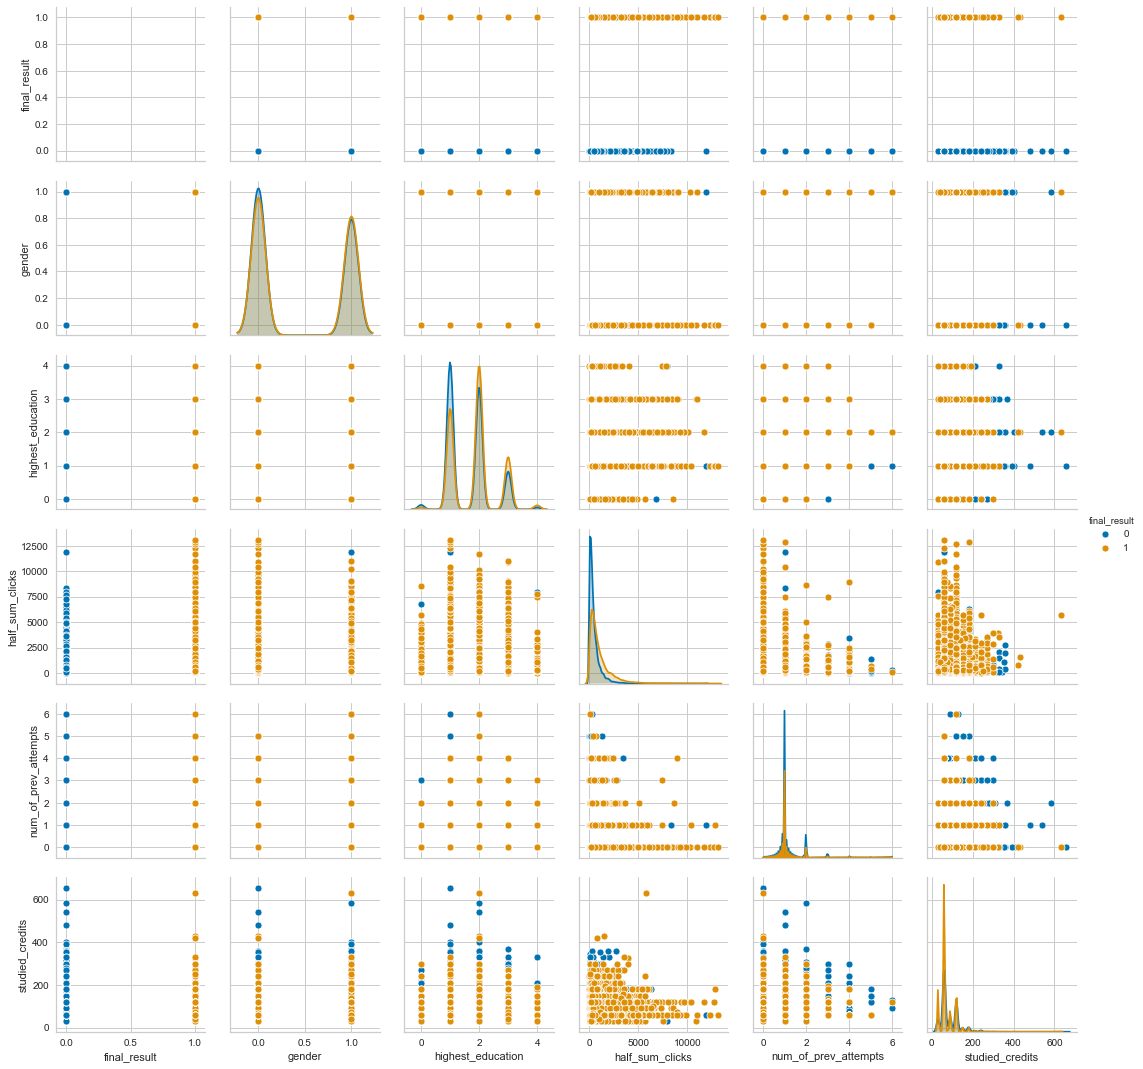

In [14]:
df_plot = df[["final_result","gender", "highest_education", "half_sum_clicks","num_of_prev_attempts", "studied_credits"]]
g = sns.pairplot(df_plot, hue="final_result")
plt.show()

In [15]:
y

array([1, 0, 1, ..., 1, 1, 1])

In [16]:
#check status of data
feature_list.head()

,code_module,module_presentation_length,num_of_prev_attempts,final_result,date_registration,disability,gender,age_band,region,highest_education,imd_band,studied_credits,b4_sum_clicks,half_sum_clicks,std_half_score
4,0,268,0,1,-159.0,0,0,2,1,3,9.0,240,98.0,612.0,81.600000
5,1,240,2,0,-47.0,0,1,0,1,1,2.0,60,14.0,147.0,38.813953
8,1,268,0,1,-27.0,0,0,0,9,2,5.0,60,6.0,365.0,89.612903
14,1,240,0,1,-73.0,0,1,0,1,1,2.0,120,5.0,1465.0,63.000000
36,1,268,0,0,-43.0,1,0,1,4,1,4.0,120,0.0,239.0,59.951613


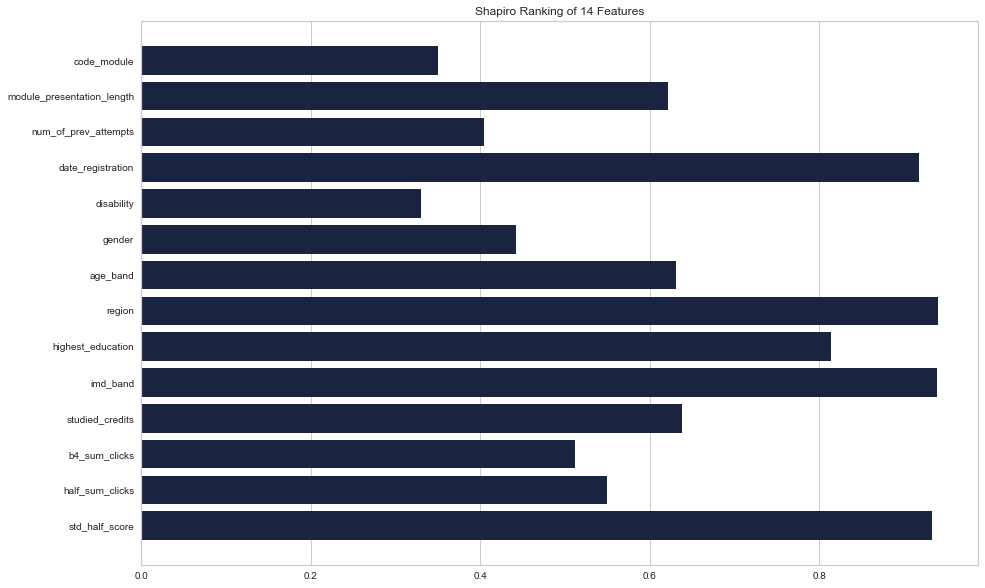

In [17]:
sns.set_palette("cubehelix")

X = feature_list[feature_list.columns.drop(['final_result'])]

y = feature_list['final_result']

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro',size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Finalize and render the figure

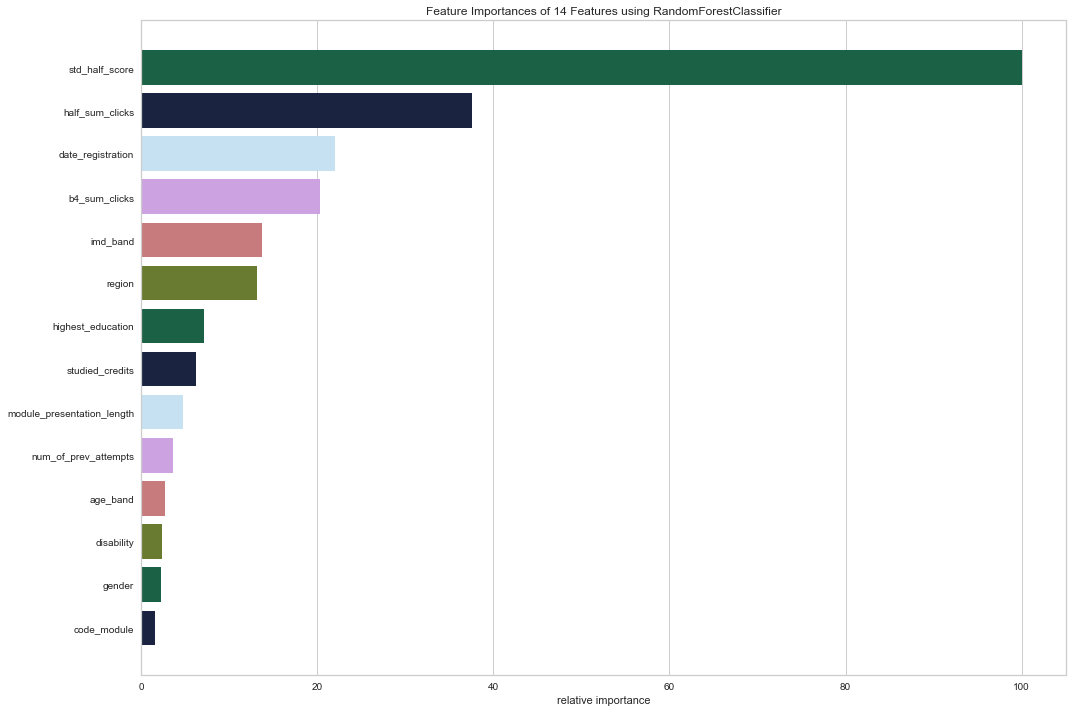

In [18]:
model = RandomForestClassifier(n_estimators=10)
feature_list = FeatureImportances(model, size=(1080, 720))
feature_list.fit(X, y)

feature_list.show()

//anaconda3/lib/python3.7/site-packages/yellowbrick/model_selection/importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


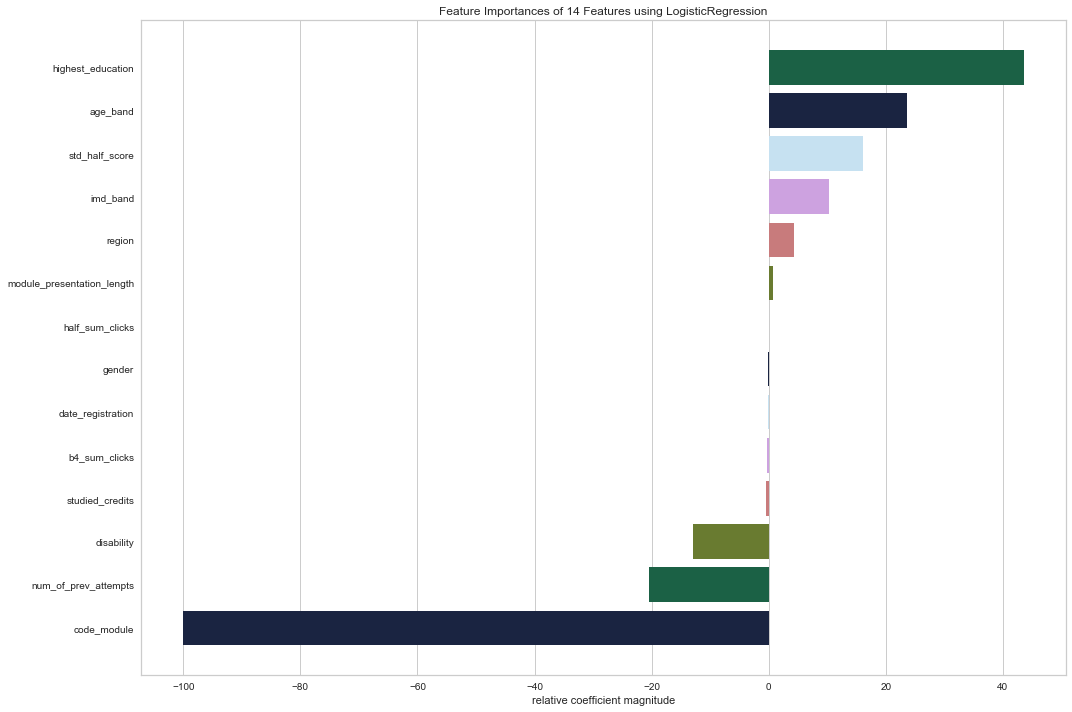

In [19]:
model = LogisticRegression()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

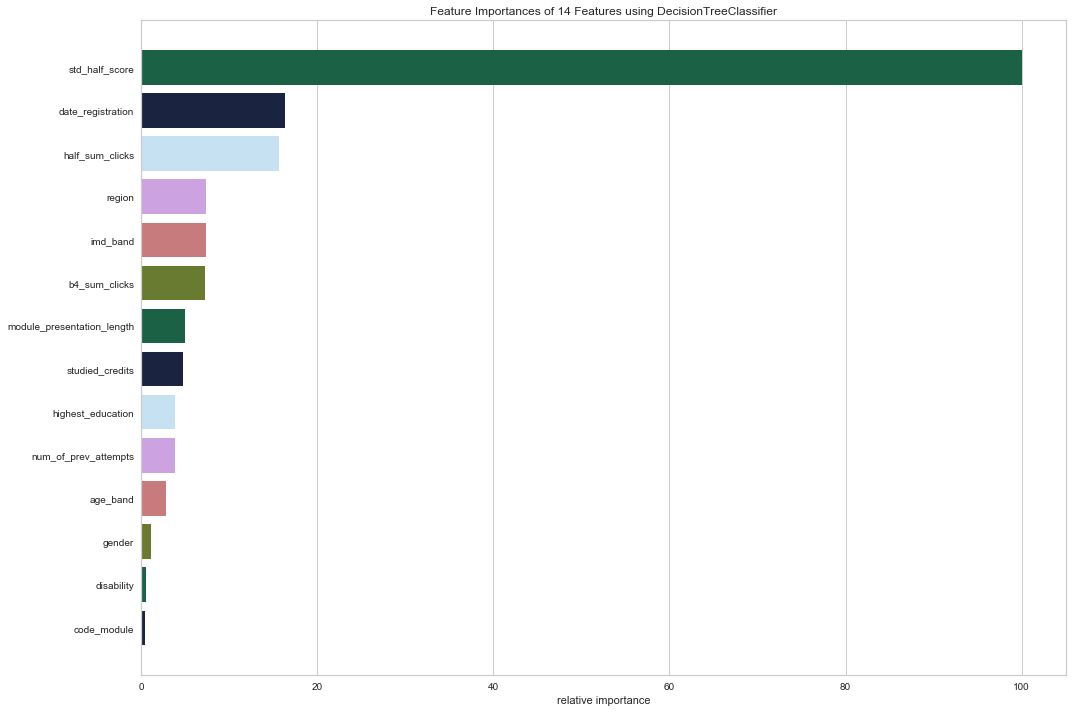

In [20]:
model = DecisionTreeClassifier()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

In [21]:
feature_list = RandomForestClassifier()
feature_list.fit(X, y)
predictions = feature_list.predict(X)
    
accuracy_score(y, predictions)

0.9910661107802263

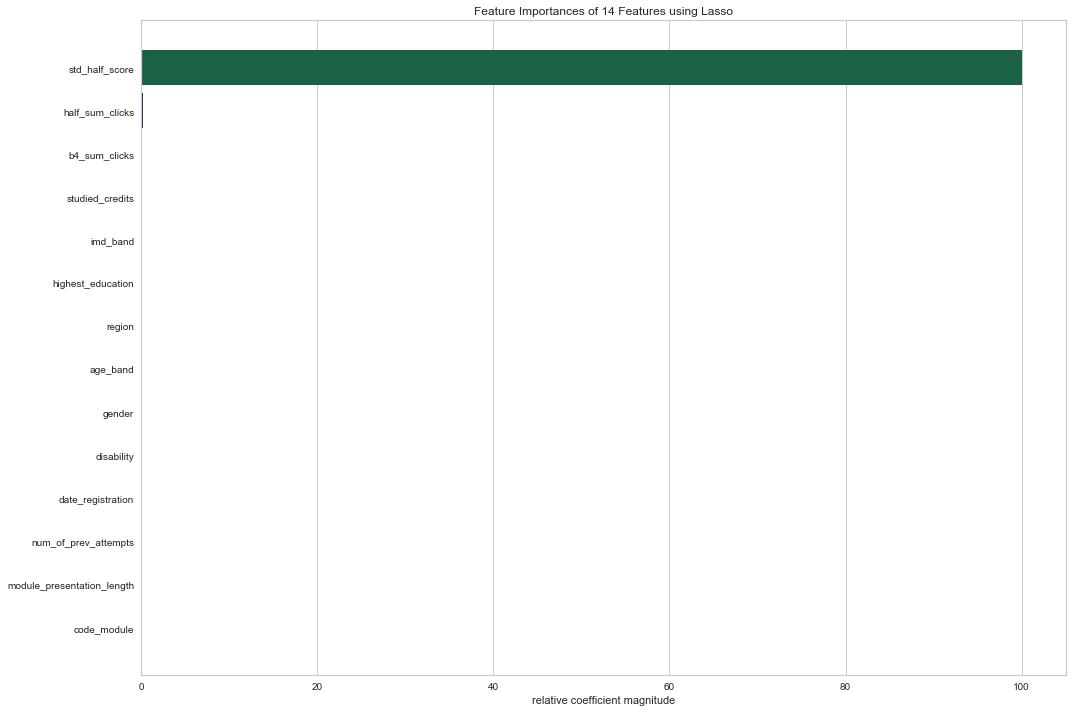

In [22]:
model = Lasso()
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
viz.show()

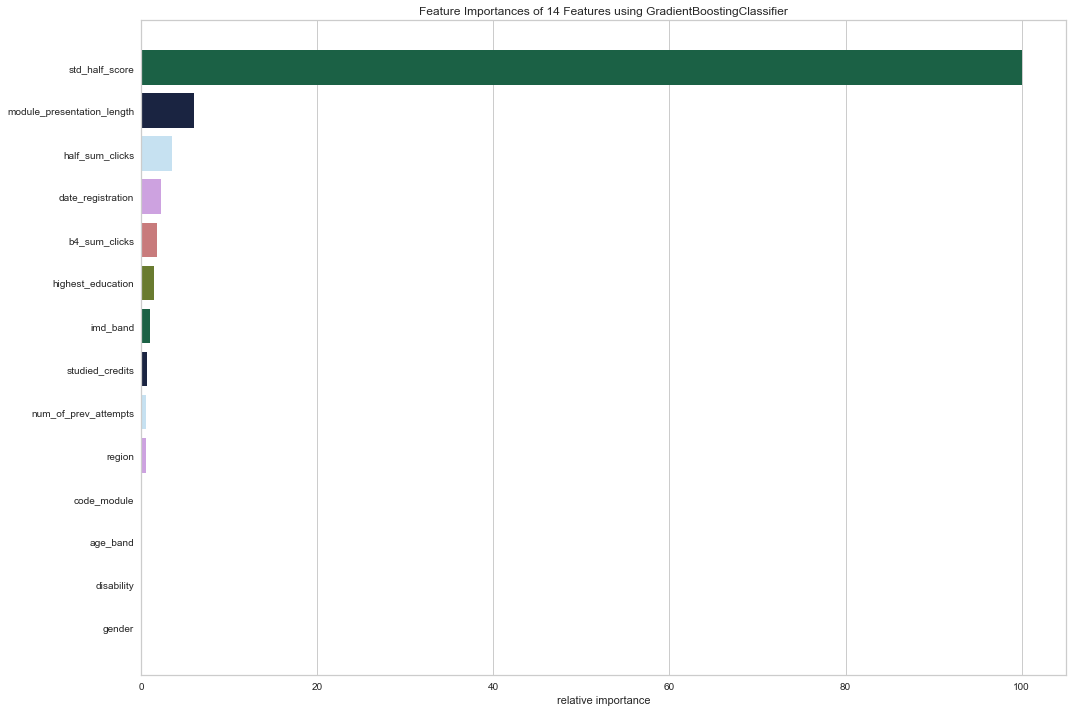

In [23]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier()
viz = FeatureImportances(model, size=(1080, 720))
viz.fit(X, y)
viz.show()

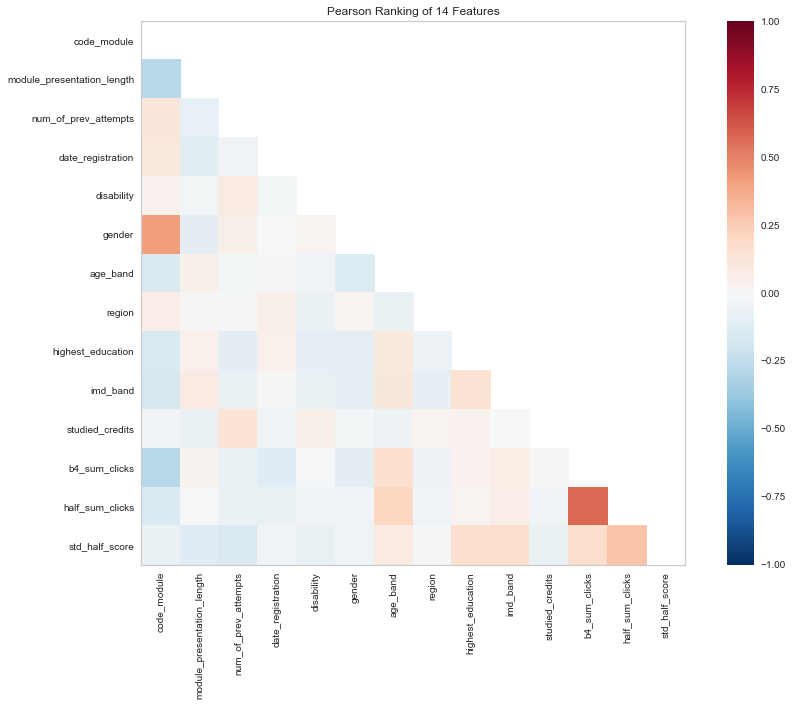

In [24]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [25]:
#features = feature_list[feature_list.columns.drop(['final_result'])]
#label = feature_list['final_result']

//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
//anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
//anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


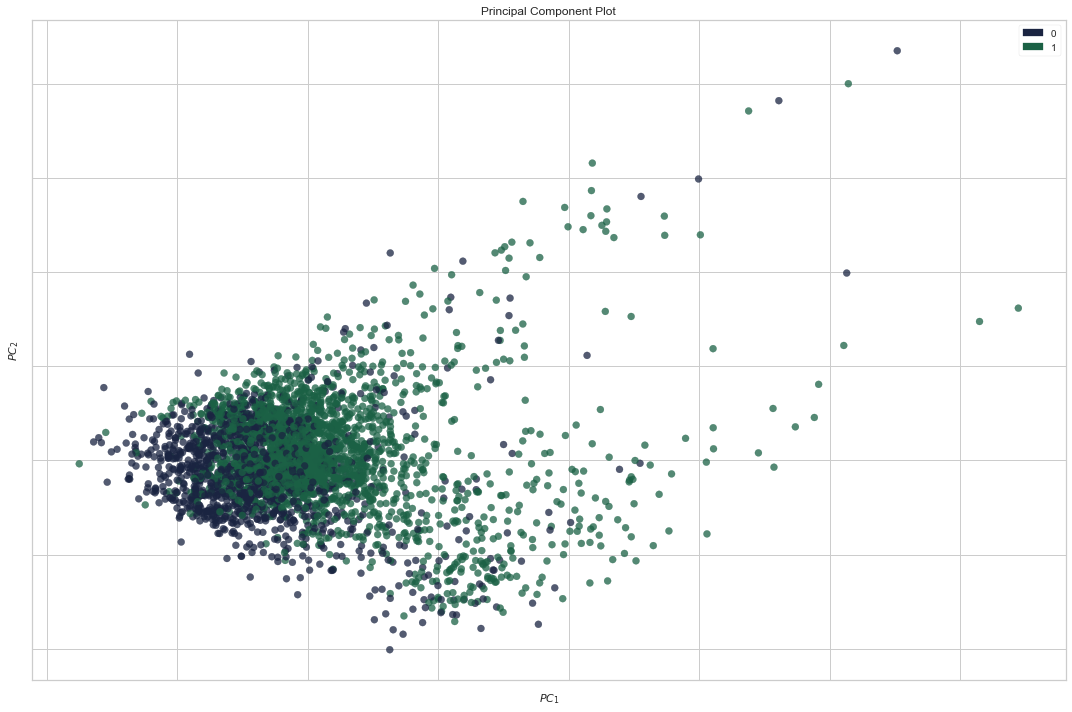

In [26]:
from yellowbrick.features.pca import PCADecomposition

# Create a list of colors to assign to points in the plot
colors = np.array(['r' if yi else 'b' for yi in y])

visualizer = PCADecomposition(
    scale=True, color=colors, size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

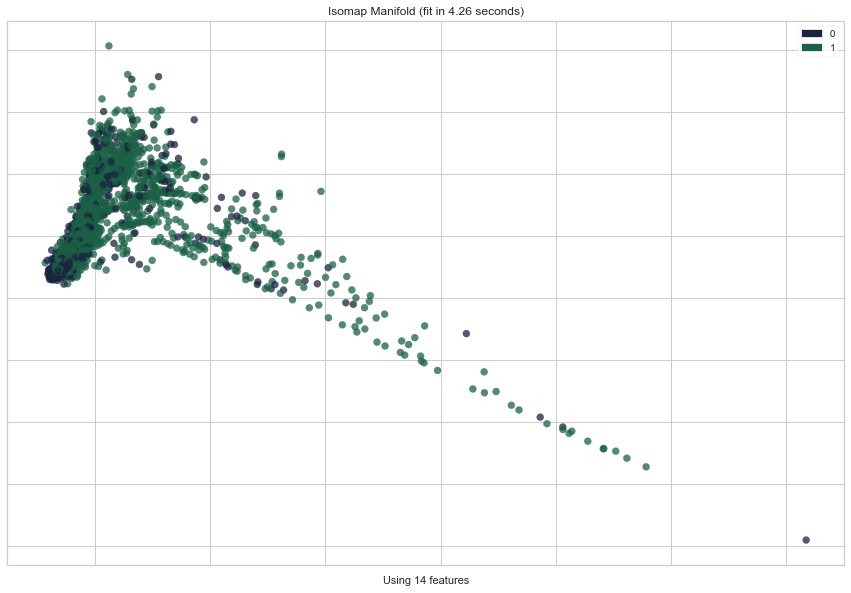

In [27]:
from yellowbrick.features.manifold import Manifold

visualizer = Manifold(
    manifold='isomap', n_neighbors=5, target='continuous', size=(1080, 720)
)
visualizer.fit(X, y)
visualizer.transform(X, y)
visualizer.show()

# Regularization Techniques

In [28]:
features = X
labels   = y

In [29]:
list(features)

['code_module',
 'module_presentation_length',
 'num_of_prev_attempts',
 'date_registration',
 'disability',
 'gender',
 'age_band',
 'region',
 'highest_education',
 'imd_band',
 'studied_credits',
 'b4_sum_clicks',
 'half_sum_clicks',
 'std_half_score']

In [30]:
model = LinearRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.008694450790913777), ('module_presentation_length', 0.005172575561400696), ('num_of_prev_attempts', -0.00544358613900265), ('date_registration', -3.503452687401016e-05), ('disability', -0.0038966856524119717), ('gender', 0.02383870961052086), ('age_band', 0.02125189722119119), ('region', 0.0030562311264026973), ('highest_education', 0.02923633868769353), ('imd_band', 0.006446639531107711), ('studied_credits', 2.6192708812009157e-05), ('b4_sum_clicks', -0.00012598227358804432), ('half_sum_clicks', 1.0450407270387943e-05), ('std_half_score', 0.012412256362693552)]


In [31]:
model = Lasso()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.0), ('module_presentation_length', 0.0), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', 0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0), ('b4_sum_clicks', -0.0), ('half_sum_clicks', 1.9276859416916396e-05), ('std_half_score', 0.010649965594913898)]


In [32]:
model = Ridge()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.008631053932468262), ('module_presentation_length', 0.005172859921327525), ('num_of_prev_attempts', -0.005439946477549104), ('date_registration', -3.5037692342233264e-05), ('disability', -0.003887750149021136), ('gender', 0.023758733148272867), ('age_band', 0.02122261229041701), ('region', 0.003055714893462563), ('highest_education', 0.029220545157314644), ('imd_band', 0.006447511280260835), ('studied_credits', 2.6186821786471544e-05), ('b4_sum_clicks', -0.00012595683885395463), ('half_sum_clicks', 1.0454377872218454e-05), ('std_half_score', 0.01241233454496663)]


In [33]:
model = ElasticNet()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', -0.0), ('module_presentation_length', 0.002563983052992607), ('num_of_prev_attempts', -0.0), ('date_registration', -0.0), ('disability', -0.0), ('gender', -0.0), ('age_band', 0.0), ('region', 0.0), ('highest_education', 0.0), ('imd_band', 0.0), ('studied_credits', -0.0), ('b4_sum_clicks', -0.0), ('half_sum_clicks', 1.2188422569584558e-05), ('std_half_score', 0.011651012187021822)]


In [34]:
model = LogisticRegression()
model.fit(features, labels)
print(list(zip(features, model.coef_.tolist())))

[('code_module', [-0.7313591976356043, -0.009563629185682513, -0.1247690740935081, -0.0007906740328309613, -0.08316905285342517, -0.00016169161213477575, 0.1378135966328173, 0.019856762535335987, 0.16116356830647197, 0.04691987278649714, -0.003005623300337404, -0.001251795875046697, 0.00011674965471710718, 0.07352622270501297])]


# Transformer Techniques

In [35]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['half_sum_clicks', 'std_half_score']


In [36]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['code_module', 'gender', 'age_band', 'highest_education', 'std_half_score']


In [37]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['module_presentation_length', 'std_half_score']


# Model Evaluation

In [38]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [39]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [40]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories = 'auto')),
        ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

for model in models:
    score_model(X, y, model)

SVC: 0.7728850721724831
NuSVC: 0.9765478424015009
LinearSVC: 0.9992909477664854
SGDClassifier: 0.990467111534795
KNeighborsClassifier: 0.8007213706041477
LogisticRegression: 0.9339686861810755


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
//ana

LogisticRegressionCV: 0.9875557642639117
BaggingClassifier: 0.986346516007533
ExtraTreesClassifier: 1.0
RandomForestClassifier: 1.0
